##### README
- the goal of this notebook is to create a simple chatbot using LangGraph

In [1]:
import dotenv
dotenv.load_dotenv(override=True)

True

In [2]:
import os
import sys

from IPython.display import Image, display
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

if not os.environ.get("OPENAI_API_KEY"):
    print("Please set your OPENAI_API_KEY environment variable.")
    # sys.exit(1) # Uncomment to enforce exit if no key found

C:\Users\Danny\Desktop\tmp\venvs\langgraph\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [3]:
# 2. Define the State
# We use TypedDict for the state. 'messages' is the key we care about.
# The `add_messages` reducer is CRITICAL: it tells LangGraph to append 
# new messages to the list rather than overwriting the whole list.
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# 3. Define the Nodes
# A node is just a python function that takes the current State and returns updates.
def chatbot_node(state: State):
    """
    This function represents the chatbot agent.
    It takes the current history, invokes the LLM, and returns the new AI message.
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
    
    # The LLM takes the full list of messages in state['messages']
    response = llm.invoke(state["messages"])
    
    # We return a dict with the key we want to update.
    # Because of `add_messages` in the State definition, this response
    # will be appended to the existing list.
    return {"messages": [response]}

# 4. Build the Graph
builder = StateGraph(State)

# Add nodes
builder.add_node("chatbot", chatbot_node)

# Add edges
# START -> chatbot -> END
# This is a simple linear flow for a single turn, but the 'memory' comes
# from the checkpointer we attach next.
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 5. Compile with Persistence (Memory)
# MemorySaver allows the graph to "remember" state between different runs 
# as long as we use the same thread_id.
memory = MemorySaver()
graph = builder.compile(checkpointer = memory)

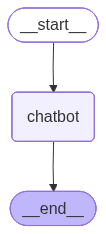

In [4]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Fallback if specific system dependencies are missing
    print(graph.get_graph().draw_mermaid())

In [5]:
# A thread_id isolates this conversation (like a session ID)
config = {"configurable": {"thread_id": "1"}}

print("--- Turn 1 ---")
user_input = "Hi, my name is Alice."
events = graph.stream(
    {"messages": [("user", user_input)]}, 
    config, 
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

--- Turn 1 ---
================================ Human Message =================================

Hi, my name is Alice.
================================== Ai Message ==================================

Hi Alice! How can I assist you today?


In [12]:
print("\n--- Turn 2 ---")
# The bot should remember the name "Alice" because of the thread_id and checkpointer
user_input_2 = "What is my name?"
events = graph.stream(
    {"messages": [("user", user_input_2)]}, 
    config, 
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()


--- Turn 2 ---
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Alice. If you have any other questions or need assistance, feel free to ask!


In [10]:
for i, e in enumerate(events):
    print(i)